## Facebook Friend Recommendation System

Project Over-view: This system aims to predict whether two people using a social media platform called Facebook will befriend each other in the near future.

Problem Statement: Our dataset consists of 2 columns each representing a node (user) and each row in the dataset represents a link (relationship) between the two nodes (users). Our aim is to find a possible future relationship between two non-connected or weakly connected nodes by performing link prediction in a graphical setting.

Data: Our dataset was selected from facebook's recruting challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting.
It consists of two columns named: source_node int64 destination_node int64

Objectives and Constraints:
The main objective is to estimate the links which are missing the dataset. 
The probalibity of a classification method is essential as it helps us to choose a number of suggestion options based on probability. The higher the probablity, the results more accurate and helps to acheive the main goal.
The most challenging part of the recommendation system is time consuming as it contains '1862220' users and the prediction for these many users to recommend the friend is a tedious task after performing EDA.

### Importing the required Libraries: 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd 
from pandas import HDFStore,DataFrame
from pandas import read_hdf
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from matplotlib import rcParams
import time
import datetime
from sklearn.cluster import MiniBatchKMeans, KMeans
import math
import gc
import pdb
import os
import pickle
import networkx as nx
from tqdm import tqdm
from IPython.display import Image
from sklearn.metrics import f1_score
from scipy.sparse.linalg import svds, eigs

### Reading and visualizing the Dataset:  

In [2]:
# Reading the Graph

fileFound = os.path.isfile('generated/train_clean.csv')
if fileFound:
    g = nx.read_edgelist('generated/train_clean.csv', delimiter = ',', create_using = nx.DiGraph(), nodetype = int)
    print(nx.info(g))
else:
    traincsv = pd.read_csv('train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of duplicate entries: ", sum(traincsv.duplicated()))
    if not os.path.exists('generated'):
        os.mkdir('generated')
    traincsv.to_csv('generated/train_clean.csv',header = False, index = False)
    print("Saved the graph into the file")

DiGraph with 1862220 nodes and 9437519 edges


DiGraph with 26 nodes and 20 edges


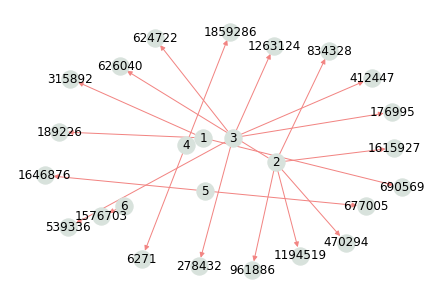

In [3]:
if not os.path.isfile('generated/sample_data.csv'):
    pd.read_csv('train.csv', nrows = 20).to_csv('generated/sample_data.csv', header = False , index = False)
subgraph = nx.read_edgelist('generated/sample_data.csv', delimiter =',', create_using = nx.DiGraph(), nodetype = int)
pos = nx.spring_layout(subgraph)
nx.draw(subgraph,pos, node_color = '#d8e2dc', edge_color = '#f28482', width = 1, edge_cmap = plt.cm.Blues, with_labels = True)
plt.savefig("generated/sample_data_graph.pdf")
print(nx.info(subgraph))

# Step 1: Exploratory Data Analysis - Investigating the data to understand it

In [4]:
# Number of Unique nodes in the graph = Total no of Unique users

g = nx.read_edgelist('generated/train_clean.csv', delimiter = ',', create_using = nx.DiGraph(), nodetype = int)
print("Total number of unique users = ", len(g.nodes()))

Total number of unique users =  1862220


### A.) Followers :

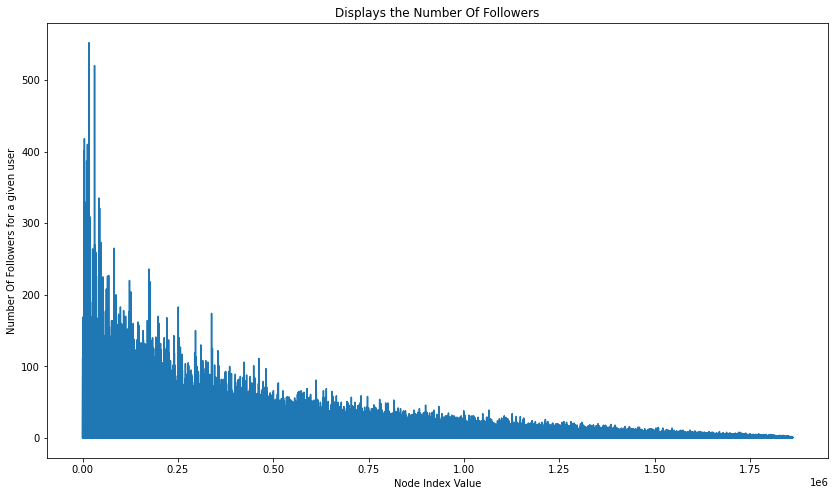

In [5]:
# Plotting a graph to display the number of followers each user possesses:

indegree_distance = list(dict(g.in_degree()).values())
plt.figure(figsize = (14,8))
plt.plot(indegree_distance)
plt.xlabel('Node Index Value')
plt.ylabel('Number Of Followers for a given user')
plt.title('Displays the Number Of Followers')
plt.show()

#### 'in_degree' denotes followers and has been used to obtain the statistics shown below.

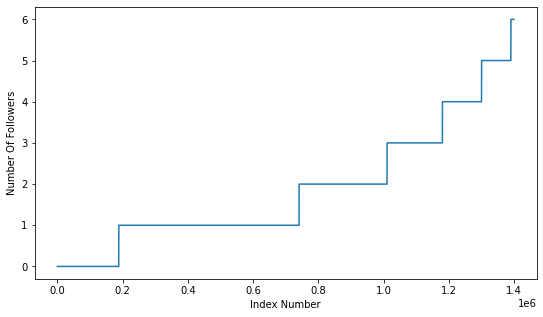

In [6]:
# Checks the first 14 Lakh nodes:

indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize = (9,5))
plt.plot(indegree_dist [0:1400000])
plt.xlabel('Index Number')
plt.ylabel('Number Of Followers')
plt.show()

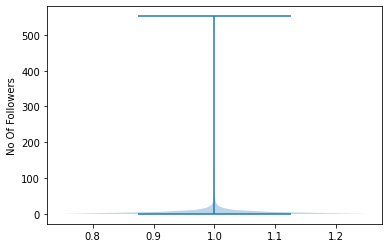

In [7]:
# Violin Plot generated:

plt.violinplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

In [8]:
# Looking for a spike in followers: 

for i in range(0,11):
    print(90+i,'percentile value is', np.percentile(indegree_dist, 90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


Spike one was seen after the 99th percentile.

In [9]:
# Narrowing in on the spike:

for i in range(10,110,10):
    print(99+(i/100),'percentile value is', np.percentile(indegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


Spike two was seen after the 99.9th percentile.

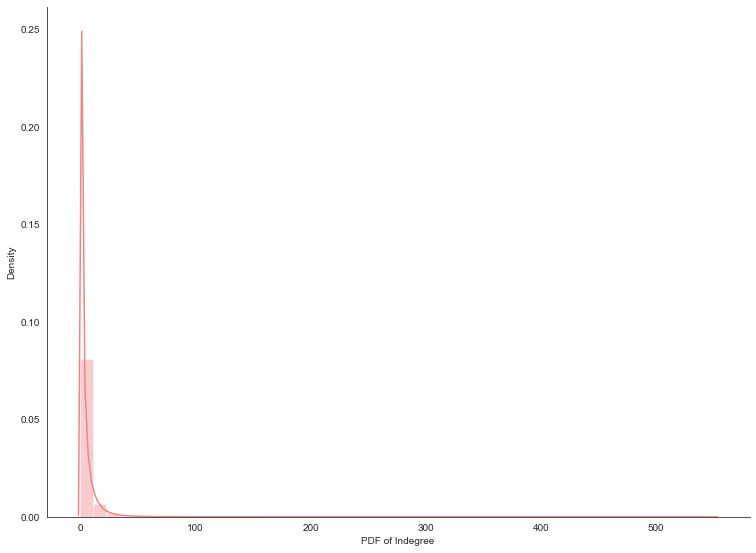

In [10]:
# Density seems to be concentrated around here because the spike happens after the 99th% (1-99th% have 40 followers) 
# Maximum number of followers a person can have is a little over 552

%matplotlib inline
sns.set_style('white')
fig, ax = plt.subplots()
fig.set_size_inches(12.6, 9.38)
sns.distplot(indegree_dist, color = '#f28482')
plt.xlabel('PDF of Indegree')
sns.despine()

In [11]:
print('Number of users not followed by any other user = ' ,sum(np.array(indegree_dist) == 0),'In terms of % is = ',
                                sum(np.array(indegree_dist) == 0)*100/len(indegree_dist) )

Number of users not followed by any other user =  188043 In terms of % is =  10.097786512871734


In [12]:
print("Maximum number of followers a user possesses = ", np.max(np.array(indegree_dist)))

Maximum number of followers a user possesses =  552


In [13]:
maximumFollowers = np.max(np.array(indegree_dist))
x = sum(np.array(indegree_dist) == maximumFollowers)
print("Number of users followed by exactly 552 people = ", x)

Number of users followed by exactly 552 people =  1


In [14]:
print("Minimum number of followers a user possesses = ", np.min(np.array(indegree_dist)))

Minimum number of followers a user possesses =  0


In [15]:
minimumFollowers = np.min(np.array(indegree_dist))
x = sum(np.array(indegree_dist) == minimumFollowers)
print("Number of users with minimum number of followers = ", x)

Number of users with minimum number of followers =  188043


In [16]:
print("Average number of followers a user possesses = ", int(np.mean(np.array(indegree_dist))))

Average number of followers a user possesses =  5


In [17]:
averageFollowers = np.mean(np.array(indegree_dist))
x = sum(np.array(indegree_dist) == int(averageFollowers))
print("Number of users having exactly 5 (the average) followers = ", x)

Number of users having exactly 5 (the average) followers =  89894


### B) Following:

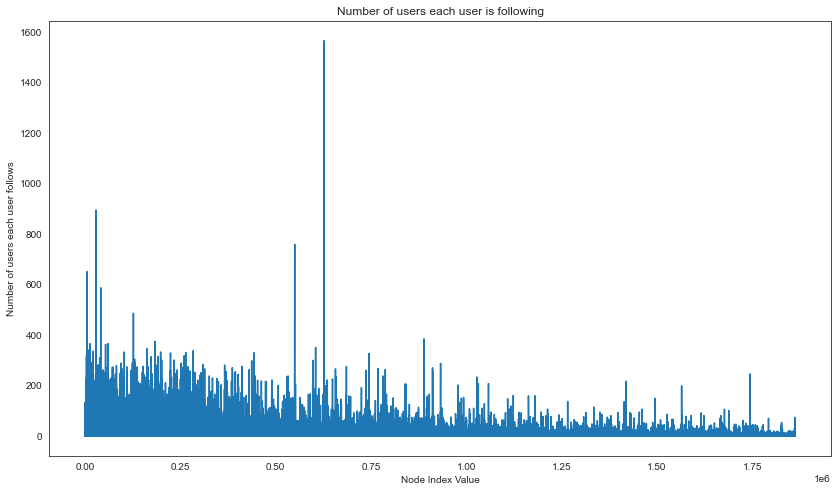

In [18]:
# Ploting a graph to display how many people a user follows:

outdegree_distance = list(dict(g.out_degree()).values())
plt.figure(figsize = (14,8))
plt.plot(outdegree_distance)
plt.xlabel('Node Index Value')
plt.ylabel('Number of users each user follows')
plt.title('Number of users each user is following')
plt.show()

#### 'out_degree' denotes the following a user does and has been used to obtain the statistics shown below.

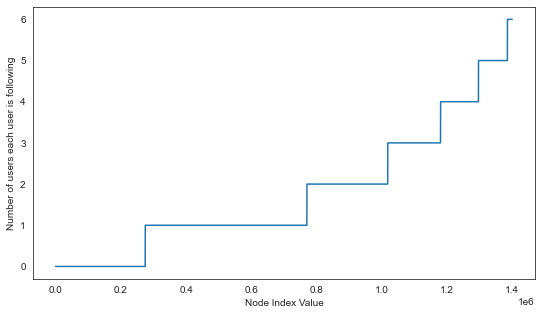

In [19]:
# Checks the first 14 Lakh nodes:

outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize = (9,5))
plt.plot(outdegree_dist[0:1400000])
plt.xlabel('Node Index Value')
plt.ylabel('Number of users each user is following')
plt.show()

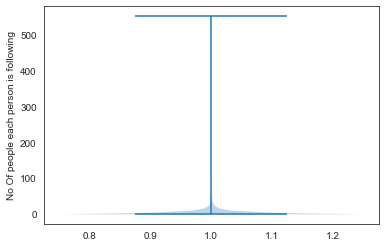

In [20]:
# Violin Plot generated:

plt.violinplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

In [21]:
# Looking for a spike in the following of a person: 

for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


Spike one was seen after the 99th percentile.

In [22]:
# Narrowing in on the spike:

for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(outdegree_dist,99+(i/100)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


Spike two was seen after the 99.9th percentile.

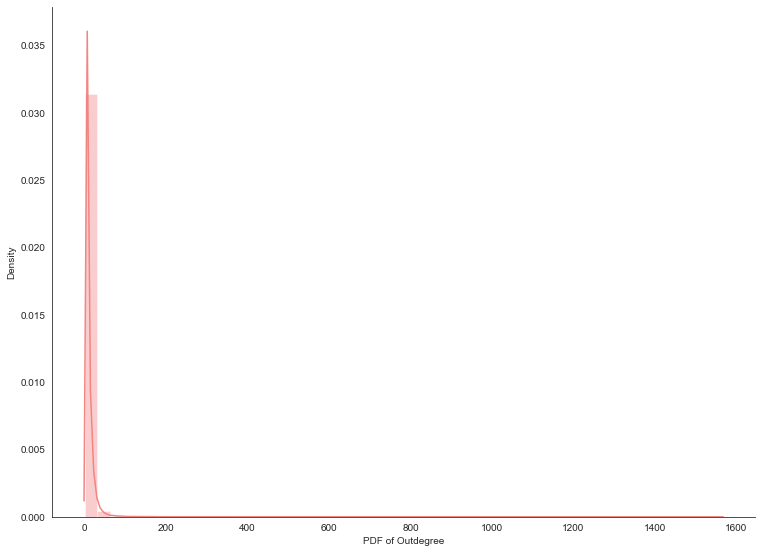

In [23]:
# Density seems to be concentrated around here because the spike happens after the 99th% (1-99th% have 40 followers) 
# Maximum number of users another user can follow is 1566

sns.set_style('white')
fig, ax = plt.subplots()
fig.set_size_inches(12.6, 9.38)
sns.distplot(outdegree_dist, color = '#f28482')
plt.xlabel('PDF of Outdegree')
sns.despine()

In [24]:
print('Number of users that do not follow anyone are = ' ,sum(np.array(outdegree_dist) == 0),'and In terms of % is = ',
                                sum(np.array(outdegree_dist) == 0)*100/len(outdegree_dist) )

Number of users that do not follow anyone are =  274512 and In terms of % is =  14.741115442858524


In [25]:
print("Maximum number of users followed by another user = ", np.max(np.array(outdegree_dist)))

Maximum number of users followed by another user =  1566


In [26]:
maximumFollowed = np.max(np.array(outdegree_dist))
x = sum(np.array(outdegree_dist) == maximumFollowed)
print("Number of users following the maximum number of users = ", x)

Number of users following the maximum number of users =  1


In [27]:
print("Minimum number of users followed by another user = ", np.min(np.array(outdegree_dist)))

Minimum number of users followed by another user =  0


In [28]:
minimumFollowed = np.min(np.array(outdegree_dist))
x = sum(np.array(outdegree_dist) == minimumFollowed)
print("Number of users that follow a minimum number of users = ", x)

Number of users that follow a minimum number of users =  274512


In [29]:
print("Average number of users followed by another user = ", int(np.mean(np.array(outdegree_dist))))

Average number of users followed by another user =  5


In [30]:
averageFollowed = np.mean(np.array(outdegree_dist))
x = sum(np.array(outdegree_dist) == int(averageFollowed))
print("Number of users following exactly 5 users = ", x)

Number of users following exactly 5 users =  88752


In [31]:
print('Number of users with zero followers are = ' ,sum(np.array(indegree_dist) == 0),'In terms of % is = ',
                                sum(np.array(indegree_dist) == 0)*100/len(indegree_dist) )

Number of users with zero followers are =  188043 In terms of % is =  10.097786512871734


In [32]:
c = 0
for i in g.nodes():
    if len(list(g.predecessors(i))) == 0 :
        if len(list(g.successors(i))) == 0:
            c+=1
print('Number of users that do not follow any other users nor do they have any followers themselves = ', c)

Number of users that do not follow any other users nor do they have any followers themselves =  0


Calculating the number of weakly connected nodes:

In [33]:
print('Number of weakly connected nodes = ',len(list(nx.weakly_connected_components(g))))
c = 0
for i in list(nx.weakly_connected_components(g)):
    if len(i) == 2:
        c+=1
print('Number of weakly connected nodes containing only 2 nodes = ', c)

Number of weakly connected nodes =  45558
Number of weakly connected nodes containing only 2 nodes =  32195


# Step 2: Splitting the data into training and testing sets  

### A) Generating all links absent from the graph a.k.a 'Missing edges'   

In [34]:
# Generated random nodes using any path and only kept those nodes whose shortest path is greater than 2
# New data stored in a folder named "generated" in a file called the "missing_weak_links file"

import random
if not os.path.isfile('generated/missing_weak_links.p'):
    r = csv.reader(open('generated/train_clean.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
    missing_edges = set([])
    while (len(missing_edges) < 9437519):
        a = random.randint(1, 1862220)
        b = random.randint(1, 1862220)
        tmp = edges.get((a,b), -1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source = a, target = b) > 2: 
                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('generated/missing_weak_links.p','wb'))
else:
    missing_edges = pickle.load(open('generated/missing_weak_links.p','rb'))

In [35]:
len(missing_edges)

9437519

### B) Data splitting:

Created the testing set by excluding edges from the given graph. The newly formed graph was also used for feature generation purposes.

In [36]:
from sklearn.model_selection import train_test_split
if ( os.path.isfile('generated/Train_Pos_Post_EDA.csv')) and ( os.path.isfile('generated/Test_Pos_Post_EDA.csv')):
    
    # Reading the entire dataset:
    df_pos = pd.read_csv('train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns = ['source_node', 'destination_node'])
    
    print("Number of nodes in the graph containing edges", df_pos.shape[0])
    print("Number of nodes in the graph that do not contain edges", df_neg.shape[0])

    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size = 0.2, random_state = 9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size = 0.2, random_state = 9)
    
    print("Number of nodes in the training data graph containing edges", X_train_pos.shape[0], "=", y_train_pos.shape[0])
    print("Number of nodes in the training data graph that do not contain edges", X_train_neg.shape[0], "=", y_train_neg.shape[0])
    print("Number of nodes in the testing data graph containing edges", X_test_pos.shape[0], "=", y_test_pos.shape[0])
    print("Number of nodes in the testing data graph that do not contain edges", X_test_neg.shape[0], "=", y_test_neg.shape[0])

    # Getting rid of the header before storing the data:
    
    X_train_pos.to_csv('generated/Train_Pos_Post_EDA.csv', header = False, index = False)
    X_test_pos.to_csv('generated/Test_Pos_Post_EDA.csv', header = False, index = False)
    X_train_neg.to_csv('generated/Train_Neg_Post_EDA.csv',header = False, index = False)
    X_test_neg.to_csv('generated/Test_Neg_Post_EDA.csv',header = False, index = False)
else:
    # Graph generated using Training data alone:
     del missing_edges

Number of nodes in the graph containing edges 9437519
Number of nodes in the graph that do not contain edges 9437519
Number of nodes in the training data graph containing edges 7550015 = 7550015
Number of nodes in the training data graph that do not contain edges 7550015 = 7550015
Number of nodes in the testing data graph containing edges 1887504 = 1887504
Number of nodes in the testing data graph that do not contain edges 1887504 = 1887504


In [37]:
#if (os.path.isfile('Train_Pos_Post_EDA.csv')) and (os.path.isfile('Test_Pos_Post_EDA.csv')):        

Training_Graph = nx.read_edgelist('./generated/Train_Pos_Post_EDA.csv', delimiter = ',', create_using = nx.DiGraph(), nodetype = int)
Testing_Graph = nx.read_edgelist('./generated/Test_Pos_Post_EDA.csv', delimiter = ',', create_using = nx.DiGraph(), nodetype = int)
print(nx.info(Training_Graph))
print(nx.info(Testing_Graph))

# Locating all Unique Nodes in each of the garphs: training and testing

Training_Nodes_POS = set(Training_Graph.nodes())
Testing_Nodes_POS = set(Testing_Graph.nodes())

print(len(Training_Nodes_POS))

TrY_TeY = len(Training_Nodes_POS.intersection(Testing_Nodes_POS))
TrY_TeN = len(Training_Nodes_POS - Testing_Nodes_POS)
TeY_TrN = len(Testing_Nodes_POS - Training_Nodes_POS)

print('Number of users that lie in both: Training and Test sets = ', TrY_TeY)
print('Number of users that lie in the Training set but not in the Testing set = ', TrY_TeN)
print('Number of users that lie in the Testing set but not in the Training set = ', TeY_TrN)
print('Percentage of users that lie in the Testing set but not in the Training set = {} %'.format(TeY_TrN / len(Testing_Nodes_POS) * 100))

DiGraph with 1780722 nodes and 7550015 edges
DiGraph with 1144623 nodes and 1887504 edges
1780722
Number of users that lie in both: Training and Test sets =  1063125
Number of users that lie in the Training set but not in the Testing set =  717597
Number of users that lie in the Testing set but not in the Training set =  81498
Percentage of users that lie in the Testing set but not in the Training set = 7.1200735962845405 %


In [38]:
# Finalizing our Testing and Training Datasets

# if (not os.path.isfile('generated/Train_post_EDA.csv')) and \
# (not os.path.isfile('generated/Test_post_EDA.csv')) and \
# (not os.path.isfile('generated/Train_Y.csv')) and \
# (not os.path.isfile('generated/Test_Y.csv')) and \
# (os.path.isfile('generated/Train_Pos_Post_EDA.csv')) and \
# (os.path.isfile('generated/Test_Pos_Post_EDA.csv')) and \
# (os.path.isfile('generated/Train_Neg_Post_EDA.csv')) and \
# (os.path.isfile('generated/Test_Neg_Post_EDA.csv')):
    
X_train_pos = pd.read_csv('generated/Train_Pos_Post_EDA.csv', names = ['source_node', 'destination_node'])
X_test_pos = pd.read_csv('generated/Test_Pos_Post_EDA.csv', names = ['source_node', 'destination_node'])
X_train_neg = pd.read_csv('generated/Train_Neg_Post_EDA.csv', names = ['source_node', 'destination_node'])
X_test_neg = pd.read_csv('generated/Test_Neg_Post_EDA.csv', names = ['source_node', 'destination_node'])


print("Number of nodes in the training graph containing edges", X_train_pos.shape[0])
print("Number of nodes in the training graph that do not contain edges", X_train_neg.shape[0])
print("Number of nodes in the testing graph containing edges", X_test_pos.shape[0])
print("Number of nodes in the testing graph that do not contain edges", X_test_neg.shape[0])

X_train = X_train_pos.append(X_train_neg, ignore_index = True)
y_train = np.concatenate((y_train_pos, y_train_neg))
X_test = X_test_pos.append(X_test_neg, ignore_index = True)
y_test = np.concatenate((y_test_pos, y_test_neg)) 

X_train.to_csv('generated/Train_post_EDA.csv', header = False, index = False)
X_test.to_csv('generated/Test_post_EDA.csv', header = False, index = False)
pd.DataFrame(y_train.astype(int)).to_csv('generated/Train_Y.csv', header = False, index = False)
pd.DataFrame(y_test.astype(int)).to_csv('generated/Test_Y.csv', header = False, index = False)

print("Number of Data points in the Training Set", X_train.shape)
print("Number of Data points in the Test Set", X_test.shape)
print("Shape of the traget variable in the Training Set", y_train.shape)
print("Shape of the traget variable in the Testing Set", y_test.shape)

Number of nodes in the training graph containing edges 7550015
Number of nodes in the training graph that do not contain edges 7550015
Number of nodes in the testing graph containing edges 1887504
Number of nodes in the testing graph that do not contain edges 1887504
Number of Data points in the Training Set (15100030, 2)
Number of Data points in the Test Set (3775008, 2)
Shape of the traget variable in the Training Set (15100030,)
Shape of the traget variable in the Testing Set (3775008,)


### C.) Data Sampling:

Sampling the data from both: Training and Testing

In [39]:
import random
#if os.path.isfile(r"generated/Train_post_EDA.csv"):
File = r"generated/Train_post_EDA.csv"
tr =  15100028
t = 100000
trskip = sorted(random.sample(range(1, tr + 1), tr - t))

#if os.path.isfile(r"generated/Test_post_EDA.csv"):
File = r"generated/Test_post_EDA.csv"
te = 3775006
t = 50000
teskip = sorted(random.sample(range(1, te + 1), te - t))
    
print("Number of rows present in: Training Data = ", tr)
print("Number of rows to be removed from Training Data = ", len(trskip))
print("Number of rows present in: Testing Data = ", te)
print("Number of rows to be removed from Testing data = ", len(teskip))

Number of rows present in: Training Data =  15100028
Number of rows to be removed from Training Data =  15000028
Number of rows present in: Testing Data =  3775006
Number of rows to be removed from Testing data =  3725006


In [40]:
DF_TrainFinal = pd.read_csv("generated/Train_post_EDA.csv", skiprows = trskip, names = ['source_node', 'destination_node'])
DF_TrainFinal['indicator_link'] = pd.read_csv("generated/Train_Y.csv", skiprows = trskip, names = ['indicator_link'])
print("The size of our Final Training matrix = ", DF_TrainFinal.shape)
DF_TrainFinal.head(5)

The size of our Final Training matrix =  (100002, 3)


,source_node,destination_node,indicator_link
0,273084,1505602,1
1,1228116,471233,1
2,1046713,1790645,1
3,436949,36283,1
4,79771,209829,1


In [41]:
DF_TestFinal = pd.read_csv("generated/Test_post_EDA.csv", skiprows = teskip, names = ['source_node', 'destination_node'])
DF_TestFinal['indicator_link'] = pd.read_csv("generated/Test_Y.csv", skiprows = teskip, names = ['indicator_link'])
print("The size of our Final Testing matrix = ", DF_TestFinal.shape)
DF_TestFinal.head(5)

The size of our Final Testing matrix =  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,665650,1202184,1
2,638605,2493,1
3,1549283,1840335,1
4,267431,226619,1


# Step 3: Generating Features -  to train our models on

### A.) Jaccard Distance:

In [42]:
# Calculated for 'Followers':

def Jaccard_Followers(a,b):
    try:
        if len(set(Training_Graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        m = (len(set(Training_Graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return m
    except:
        return 0
    
# Calculated for 'Following': 

def Jaccard_Following(a,b):
    try:
        if len(set(Training_Graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        m = (len(setTraining_Graph.successors(a)).intersection(set(train_graph.successors(b))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return m

In [43]:
# Test case

print(Jaccard_Followers(266666,1555555))

0


In [44]:
# Test case

print(Jaccard_Following(266666,1555555))

0


### B.) Cosine distance:

In [45]:
# Calculated for 'Followers':

def Cosine_Followers(a,b):
    try:
        
        if len(set(Training_Graph.predecessors(a))) == 0  | len(set(Training_Graph.predecessors(b))) == 0:
            return 0
        m = (len(set(Training_Graph.predecessors(a)).intersection(set(Training_Graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(Training_Graph.predecessors(a)))) * (len(set(Training_Graph.predecessors(b)))))
        return m
    except:
        return 0
    
# Calculated for 'Following': 

def Cosine_Following(a,b):
    try:
        if len(set(Training_Graph.successors(a))) == 0  | len(set(Training_Graph.successors(b))) == 0:
            return 0
        m = (len(set(Training_Graph.successors(a)).intersection(set(Training_Graph.successors(b)))))/\
                                    (math.sqrt(len(set(Training_Graph.successors(a))) * len((set(Training_Graph.successors(b))))))
        return m
    except:
        return 0

In [46]:
# Test case

print(Cosine_Followers(266666,1555555))


0.0


In [47]:
# Test case

print(Cosine_Following(266666,1555555))

0


### C.) Ranking Measures - Page Ranking

In [48]:
# Page ranking: Calculates the number as well as quality of links to a node to estimate the importance of that node.

if not os.path.isfile('generated/PageRank.p'):
    page_rank = nx.pagerank(Training_Graph, alpha = 0.91)
    pickle.dump(page_rank, open('generated/PageRank.p','wb'))
else:
    page_rank = pickle.load(open('generated/PageRank.p','rb'))
    
page_rank_mean = float(sum(page_rank.values())) / len(page_rank)
print('Mean = ', float(sum(page_rank.values())) / len(page_rank))
print('Maximum = ', page_rank[max(page_rank, key = page_rank.get)])
print('Minimum = ', page_rank[min(page_rank, key = page_rank.get)])

Mean =  5.615699699389075e-07
Maximum =  2.709825134193587e-05
Minimum =  1.6556497245737814e-07


### D.) Calculating the Shortest path:

In [49]:
# If two nodes are linked via a direct path then that edge is gotten rid of the the path is calculated.

def Calculate_the_length_of_Shortest_path(a,b):
    shortest_path = -1
    try:
        if Training_Graph.has_edge(a,b):
            Training_Graph.remove_edge(a,b)
            shortest_path = nx.shortest_path_length(Training_Graph, source = a, target = b)
            Training_Graph.add_edge(a,b)
        else:
            shortest_path = nx.shortest_path_length(Training_Graph, source = a, target = b)
        return shortest_path
    except:
        return -1

In [50]:
# Test case

print(Calculate_the_length_of_Shortest_path(266666,1555555))


-1


### E.) Community Check:

In [51]:
# Procuring all Weekly Connected Edges: 

CC = list(nx.weakly_connected_components(Training_Graph))
def Community_Check(a,b):
    index = []
    if Training_Graph.has_edge(b,a):
        return 1
    if Training_Graph.has_edge(a,b):
            for i in CC:
                if a in i:
                    index = i
                    break
            if (b in index):
                Training_Graph.remove_edge(a,b)
                if Calculate_the_length_of_Shortest_path(a,b) == -1:
                    Training_Graph.add_edge(a,b)
                    return 0
                else:
                    Training_Graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in CC:
                if a in i:
                    index = i
                    break
            if(b in index):
                return 1
            else:
                return 0

In [52]:
# Test case

print(Community_Check(266666,1555555))


1


### F.) Adamic Index:

In [53]:
# Also called Adar index: inverted sum of degrees of common neighbours for given two vertices

def Adar_Index_Calculation(a,b):
    sum = 0
    try:
        adar_index = list(set(Training_Graph.successors(a)).intersection(set(Training_Graph.successors(b))))
        if len(adar_index)!= 0:
            for i in adar_index:
                sum = sum + (1/np.log10(len(list(Training_Graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

### G.) Do I get a follow back? 

In [54]:
def FollowsMeBack(a,b):
    if Training_Graph.has_edge(b,a):
        return 1
    else:
        return 0

In [55]:
# Test case

print(FollowsMeBack(266666,1555555))

0


### H.) Katz Centrality:

In [56]:
# Katz centrality computes the centrality for a node based on the centrality of its neighbors. It is a generalization of the eigenvector centrality. 

if not os.path.isfile('generated/KatzCentrality.p'):
    katz = nx.katz.katz_centrality(Training_Graph, alpha = 0.003, beta = 1)
    pickle.dump(katz, open('generated/KatzCentrality.p','wb'))
else:
    katz = pickle.load(open('generated/KatzCentrality.p','rb'))
    
print('Mean =', float(sum(katz.values())) / len(katz))
print('Maximum =', katz[max(katz, key = katz.get)])
k_mean = float(sum(katz.values())) / len(katz)
print('Minimum =', katz[min(katz, key = katz.get)])

Mean = 0.0007483800935562018
Maximum = 0.003394554981699122
Minimum = 0.0007313532484065916


### I.) Hits score:

In [57]:
if not os.path.isfile('generated/HitsScore.p'):
    hits = nx.hits(Training_Graph, max_iter = 50, tol = 1e-07, nstart = None, normalized = True)
    pickle.dump(hits,open('generated/HitsScore.p','wb'))
else:
    hits = pickle.load(open('generated/HitsScore.p','rb'))
    
print('Mean =', float(sum(hits[0].values())) / len(hits[0]))
print('Maximum =', hits[0][max(hits[0], key = hits[0].get)])
print('Minimum =', hits[0][min(hits[0], key = hits[0].get)])

Mean = 5.615699699308671e-07
Maximum = 0.004868653379538976
Minimum = -1.8730330014378374e-19


## Step 4: Featurization - Conversting the data into numerical values

Generating each of the aforementioned features for both: Training and Testing data points

In [58]:
if not os.path.isfile(r'generated/StorageSample_Phase1.h5'):
    
    # Mapping the Cosine distance feature to both: training and testing data
    
    DF_TrainFinal['Cosine_Followers'] = DF_TrainFinal.apply(lambda row:
                                            Cosine_Followers(row['source_node'], row['destination_node']), axis = 1)
    DF_TestFinal['Cosine_Followers'] = DF_TestFinal.apply(lambda row:
                                            Cosine_Followers(row['source_node'], row['destination_node']), axis = 1)

    DF_TrainFinal['Cosine_Following'] = DF_TrainFinal.apply(lambda row:
                                            Cosine_Following(row['source_node'], row['destination_node']), axis = 1)
    DF_TestFinal['Cosine_Following'] = DF_TestFinal.apply(lambda row:
                                            Cosine_Following(row['source_node'], row['destination_node']), axis = 1)
    
    # Mapping the jaccardian distance feature to both: training and testing data
    
    DF_TrainFinal['Jaccard_Followers'] = DF_TrainFinal.apply(lambda row:
                                            Jaccard_Followers(row['source_node'], row['destination_node']), axis = 1)
    DF_TestFinal['Jaccard_Followers'] = DF_TestFinal.apply(lambda row:
                                            Jaccard_Followers(row['source_node'], row['destination_node']), axis = 1)

    DF_TrainFinal['Jaccard_Following'] = DF_TrainFinal.apply(lambda row:
                                            Jaccard_Following(row['source_node'], row['destination_node']), axis = 1)
    DF_TestFinal['Jaccard_Following'] = DF_TestFinal.apply(lambda row:
                                            Jaccard_Following(row['source_node'], row['destination_node']), axis = 1)
    


In [59]:
# Computing the number of: Following & Followers for 'source' and 'destination'
# Computing the intersection for: Following & Followers for 'source' and 'destination'

def GenerateFeatures_Phase1(DF_Final):
    No_Followers_source = []
    No_Following_source = []
    No_Followers_destinaion = []
    No_Following_destination = []
    Intersection_Followers = []
    Intersection_Following = []
    for i, row in DF_Final.iterrows():
        try:
            S1 = set(Training_Graph.predecessors(row['source_node']))
            S2 = set(Training_Graph.successors(row['source_node']))
        except:
            S1 = set()
            S2 = set()
        try:
            D1 = set(Training_Graph.predecessors(row['destination_node']))
            D2 = set(Training_Graph.successors(row['destination_node']))
        except:
            D1 = set()
            D2 = set()
        No_Followers_source.append(len(S1))
        No_Following_source.append(len(S2))

        No_Followers_destinaion.append(len(D1))
        No_Following_destination.append(len(D2))

        Intersection_Followers.append(len(S1.intersection(D1)))
        Intersection_Following.append(len(S2.intersection(D2)))
    return No_Followers_source, No_Following_source, No_Followers_destinaion, No_Following_destination, Intersection_Followers, Intersection_Following

In [60]:
# Deciding upon columns for our final training dataset

import os
if not os.path.isfile(r'generated/StorageSample_Phase1.h5'):
    DF_TrainFinal['No_Followers_destinaion'], DF_TrainFinal['No_Followers_source'], \
    DF_TrainFinal['No_Following_source'], DF_TrainFinal['No_Following_destinaion'], \
    DF_TrainFinal['Intersection_Followers'], DF_TrainFinal['Intersection_Following'] = GenerateFeatures_Phase1(DF_TrainFinal)
    
    DF_TestFinal['No_Followers_source'], DF_TestFinal['No_Followers_destinaion'], \
    DF_TestFinal['No_Following_source'], DF_TestFinal['No_Following_destinaion'], \
    DF_TestFinal['Intersection_Followers'], DF_TestFinal['Intersection_Following'] = GenerateFeatures_Phase1(DF_TestFinal)
    
    hdf = HDFStore(r'generated/StorageSample_Phase1.h5')
    hdf.put('Train_DF', DF_TrainFinal, format = 'table', data_columns = True)
    hdf.put('Test_DF', DF_TestFinal, format = 'table', data_columns = True)
    hdf.close()
else:
    DF_TrainFinal = read_hdf(r'generated/StorageSample_Phase1.h5', 'Train_DF', mode = 'r')
    DF_TestFinal = read_hdf(r'generated/StorageSample_Phase1.h5', 'Test_DF', mode = 'r')

In [61]:
# Visulaizing our Training data columns

DF_TrainFinal.columns

Index(['source_node', 'destination_node', 'indicator_link', 'Cosine_Followers',
       'Cosine_Following', 'Jaccard_Followers', 'Jaccard_Following',
       'No_Followers_destinaion', 'No_Followers_source', 'No_Following_source',
       'Intersection_Followers', 'Intersection_Following'],
      dtype='object')

In [65]:
if not os.path.isfile(r'generated/StorageSample_Phase2.h5'):
    
    # Mapping the adar index feature to both: training and testing data
    
    DF_TrainFinal['Adar_Index'] = DF_TrainFinal.apply(lambda row: Adar_Index_Calculation(row['source_node'], row['destination_node']), axis = 1)

    DF_TestFinal['Adar_Index'] = DF_TestFinal.apply(lambda row: Adar_Index_Calculation(row['source_node'], row['destination_node']), axis = 1)

    # Mapping the Do I get a Follow back? feature to both: training and testing data
    
    DF_TrainFinal['FollowBack'] = DF_TrainFinal.apply(lambda row: FollowsMeBack(row['source_node'], row['destination_node']), axis = 1)

    DF_TestFinal['FollowBack'] = DF_TestFinal.apply(lambda row: FollowsMeBack(row['source_node'], row['destination_node']), axis = 1)

    # Mapping the Community Check feature to both: training and testing data
    
    DF_TrainFinal['CommunityCheck'] = DF_TrainFinal.apply(lambda row: Community_Check(row['source_node'], row['destination_node']), axis = 1)

    DF_TestFinal['CommunityCheck'] = DF_TestFinal.apply(lambda row: Community_Check(row['source_node'], row['destination_node']), axis = 1)
    
    # Mapping the Shoretest Path feature to both: training and testing data
    
    DF_TrainFinal['ShoretestPath'] = DF_TrainFinal.apply(lambda row: Calculate_the_length_of_Shortest_path(row['source_node'], row['destination_node']), axis = 1)
    
    DF_TestFinal['Shoretest Path'] = DF_TestFinal.apply(lambda row: Calculate_the_length_of_Shortest_path(row['source_node'], row['destination_node']), axis = 1)

    hdf = HDFStore(r'generated/StorageSample_Phase2.h5')
    hdf.put('train_df', DF_TrainFinal, format = 'table', data_columns = True)
    hdf.put('test_df', DF_TestFinal, format = 'table', data_columns = True)
    hdf.close()
else:
    DF_TrainFinal = read_hdf(r'generated/StorageSample_Phase2.h5', 'train_df', mode = 'r')
    DF_TestFinal = read_hdf(r'generated/StorageSample_Phase2.h5', 'test_df', mode = 'r')


In [66]:
# Visualizing our training data columns

DF_TrainFinal.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_d', 'num_followers_s',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path'],
      dtype='object')

### Creating weighted features for both: Training and Testing points

#### Weight Features

In order to determine the similarity of nodes, edge weight values were calculated between nodes. Edge weight is inversely proportional to the neighbor count. 

In [67]:
# Calculating the weighted features for each link for both: Source and Destination

Weight_IN = {}
Weight_OUT = {}

for i in  tqdm(Training_Graph.nodes()):
    S1 = set(Training_Graph.predecessors(i))
    W_IN = 1.0/(np.sqrt(1 + len(S1)))
    Weight_IN[i] = W_IN
    
    S2 = set(Training_Graph.successors(i))
    W_OUT = 1.0/(np.sqrt(1 + len(S2)))
    Weight_OUT[i] = W_OUT
    
# Input using Mean

Weight_IN_Mean = np.mean(list(Weight_IN.values()))
Weight_OUT_Mean = np.mean(list(Weight_OUT.values()))

100%|██████████████████████████████| 1780722/1780722 [00:42<00:00, 41478.68it/s]


In [68]:
if not os.path.isfile(r'generated/StorageSample_Phase3.h5'):
    
    # Mapping the features to both: training and testing points 

    DF_TrainFinal['Weight_IN'] = DF_TrainFinal.destination_node.apply(lambda x: Weight_IN.get(x, Weight_IN_Mean))
    DF_TrainFinal['Weight_OUT'] = DF_TrainFinal.source_node.apply(lambda x: Weight_OUT.get(x, Weight_OUT_Mean))

    DF_TestFinal['Weight_IN'] = DF_TestFinal.destination_node.apply(lambda x: Weight_IN.get(x, Weight_IN_Mean))
    DF_TestFinal['Weight_OUT'] = DF_TestFinal.source_node.apply(lambda x: Weight_OUT.get(x, Weight_OUT_Mean))

    # Performing Feature Engineering:
    
    DF_TrainFinal['WeightF1'] = DF_TrainFinal.weight_in + DF_TrainFinal.Weight_OUT
    DF_TrainFinal['WeightF2'] = DF_TrainFinal.weight_in * DF_TrainFinal.Weight_OUT
    DF_TrainFinal['WeightF3'] = (2 * DF_TrainFinal.weight_in + 1*DF_TrainFinal.Weight_OUT)
    DF_TrainFinal['WeightF4'] = (1 * DF_TrainFinal.weight_in + 2*DF_TrainFinal.Weight_OUT)

    DF_TestFinal['WeightF1'] = DF_TestFinal.weight_in + DF_TestFinal.weight_out
    DF_TestFinal['WeightF2'] = DF_TestFinal.weight_in * DF_TestFinal.weight_out
    DF_TestFinal['WeightF3'] = (2 * DF_TestFinal.weight_in + 1 * DF_TestFinal.weight_out)
    DF_TestFinal['WeightF4'] = (1 * DF_TestFinal.weight_in + 2 * dDF_TestFinal.weight_out)

In [70]:
if not os.path.isfile(r'generated/StorageSample_Phase3.h5'):
    
    # Calculating the page ranking for both: source and destination in both: Training and Testing Sets
    # In case, there the training graph has missing values, then the mean page rank has been added 
    
    DF_TrainFinal['PageRank_S'] = DF_TrainFinal.source_node.apply(lambda x:page_rank.get(x, page_rank_mean))
    DF_TrainFinal['PageRank_D'] = DF_TrainFinal.destination_node.apply(lambda x:page_rank.get(x, page_rank_mean))

    DF_TestFinal['PageRank_S'] = DF_TestFinal.source_node.apply(lambda x:page_rank.get.get(x, page_rank_mean))
    DF_TestFinal['PageRank_D'] = DF_TestFinal.destination_node.apply(lambda x:page_rank.get.get(x, page_rank_mean))

    # Calculating the Katz centrality score for both: source and destination in both: Training and Testing Sets
    # In case, there the training graph has missing values, then the mean katz score has been added
    
    DF_TrainFinal['Katz_S'] = DF_TrainFinal.source_node.apply(lambda x: katz.get(x, k_mean))
    DF_TrainFinal['Katz_D'] = DF_TrainFinal.destination_node.apply(lambda x: katz.get(x, k_mean))

    DF_TestFinal['Katz_S'] = DF_TestFinal.source_node.apply(lambda x: katz.get(x, k_mean))
    DF_TestFinal['Katz_D'] = DF_TestFinal.destination_node.apply(lambda x: katz.get(x, k_mean))

    # Calculating the Hits score for both: source and destination in both: Training and Testing Sets
    # In case, there the training graph has missing values, then it has been replaced with a zero
    
    DF_TrainFinal['Hits_S'] = DF_TrainFinal.source_node.apply(lambda x: hits[0].get(x, 0))
    DF_TrainFinal['Hits_D'] = DF_TrainFinal.destination_node.apply(lambda x: hits[0].get(x, 0))

    DF_TestFinal['Hits_S'] = DF_TestFinal.source_node.apply(lambda x: hits[0].get(x, 0))
    DF_TestFinal['Hits_D'] = DF_TestFinal.destination_node.apply(lambda x: hits[0].get(x, 0))

    DF_TrainFinal['Authorities_S'] = DF_TrainFinal.source_node.apply(lambda x: hits[1].get(x, 0))
    DF_TrainFinal['Authorities_D'] = DF_TrainFinal.destination_node.apply(lambda x: hits[1].get(x, 0))

    DF_TestFinal['Authorities_S'] = DF_TestFinal.source_node.apply(lambda x: hits[1].get(x, 0))
    DF_TestFinal['Authorities_D'] = DF_TestFinal.destination_node.apply(lambda x: hits[1].get(x, 0))

    hdf = HDFStore(r'generated/StorageSample_Phase3.h5')
    hdf.put('Train_DF', DF_TrainFinal, format = 'table', data_columns = True)
    hdf.put('Test_DF', DF_TestFinal, format = 'table', data_columns = True)
    hdf.close()
else:
    DF_TrainFinal = read_hdf(r'generated/StorageSample_Phase3.h5', 'train_df', mode = 'r')
    DF_TestFinal = read_hdf(r'generated/StorageSample_Phase3.h5', 'test_df', mode = 'r')

In [71]:
DF_TestFinal.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees', 'adar_index', 'follows_back', 'same_comp',
       'shortest_path', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d'],
      dtype='object')

### Adding SVD_DOT features for both: training and testing data points

SVD_DOT features have been created by calculating the dot prouct between the source and destination nodes.
The Dot product of columns: source and destination give SVD features in the form oflow-rank approximation

In [79]:
def SVD_DOT(x, SVD):
    try:
        l = sadj_dict[x]
        return SVD[l]
    except:
        return [0,0,0,0,0,0]

In [80]:
# Creating a dictionary node called 'val' in SVD Vector

SVD_C = sorted(Training_Graph.nodes())
SVD_D = { val:idx for idx, val in enumerate(SVD_C)}

In [81]:
ADJ = nx.adjacency_matrix(Training_Graph, nodelist = sorted(Training_Graph.nodes())).asfptype()

In [82]:
U, s, V = svds(ADJ, k = 6)
print('Adjacency matrix Shape', ADJ.shape)
print('Shape of: U',U.shape)
print('Shape of: V',V.shape)
print('Shape of: s',s.shape)

Adjacency matrix Shape (1780722, 1780722)
Shape of: U (1780722, 6)
Shape of: V (6, 1780722)
Shape of: s (6,)


### Perfoming: Preferential Attachment

Users with a higher number of 'friends/follwers' are more inclined to creating even more connections in the future.

We estimate how ”rich” our two vertices are by multiplying the number followers each vertex has. It may be noted that the similarity index does not require any node neighbor information, therefore, this similarity index has the lowest computational complexity.

                 preferential_attachment = friendsof(a) * friendsof(b)

In [83]:
# Defining the functions:

def PA_Following(a,b):
    
    try:
        person_a = len(set(Training_graph.successors(a)))
        person_b = len(set(Training_Graph.successors(b)))
        return person_a * person_b
    except:
        return 0

def PA_Followers(a,b):
    
    try:
        person_a = len(set(Training_Graph.predecessors(a)))
        person_b = len(set(Training_Graph.predecessors(b)))
        return person_a * person_b
    except:
        return 0

In [84]:
# Test cases

print(PA_Following(266666,1555555))
print(PA_Followers(266666,1555555))

0
60


In [86]:
 
if not os.path.isfile(r'generated/StorageSample_Phase4.h5'):
    
    DF_TrainFinal[['SVD_U_S_1', 'SVD_U_S_2','SVD_U_S_3', 'SVD_U_S_4', 'SVD_U_S_5', 'SVD_U_S_6']] = \
    DF_TrainFinal.source_node.apply(lambda x: SVD_DOT(x, U)).apply(pd.Series)
    
    DF_TrainFinal[['SVD_U_D_1', 'SVD_U_D_2', 'SVD_U_D_3', 'SVD_U_D_4', 'SVD_U_D_5','SVD_U_D_6']] = \
    DF_TrainFinal.destination_node.apply(lambda x: SVD_DOT(x, U)).apply(pd.Series)
    
    DF_TrainFinal[['SVD_V_S_1','SVD_V_S_2', 'SVD_V_S_3', 'SVD_V_S_4', 'SVD_V_S_5', 'SVD_V_S_6',]] = \
    DF_TrainFinal.source_node.apply(lambda x: SVD_DOT(x, V.T)).apply(pd.Series)

    DF_TrainFinal[['SVD_V_D_1', 'SVD_V_D_2', 'SVD_V_D_3', 'SVD_V_D_4', 'SVD_V_D_5','SVD_V_D_6']] = \
    DF_TrainFinal.destination_node.apply(lambda x: SVD_DOT(x, V.T)).apply(pd.Series)
    
    DF_TestFinal[['SVD_U_S_1', 'SVD_U_S_2','SVD_U_S_3', 'SVD_U_S_4', 'SVD_U_S_5', 'SVD_U_S_6']] = \
    DF_TestFinal.source_node.apply(lambda x: SVD_DOT(x, U)).apply(pd.Series)
    
    DF_TestFinal[['SVD_U_D_1', 'SVD_U_D_2', 'SVD_U_D_3', 'SVD_U_D_4', 'SVD_U_D_5','SVD_U_D_6']] = \
    DF_TestFinal.destination_node.apply(lambda x: SVD_DOT(x, U)).apply(pd.Series)
    
    DF_TestFinal[['SVD_V_S_1','SVD_V_S_2', 'SVD_V_S_3', 'SVD_V_S_4', 'SVD_V_S_5', 'SVD_V_S_6',]] = \
    DF_TestFinal.source_node.apply(lambda x: SVD_DOT(x, V.T)).apply(pd.Series)

    DF_TestFinal[['SVD_V_D_1', 'SVD_V_D_2', 'SVD_V_D_3', 'SVD_V_D_4', 'SVD_V_D_5','SVD_V_D_6']] = \
    DF_TestFinal.destination_node.apply(lambda x: SVD_DOT(x, V.T)).apply(pd.Series)
        
     
    DF_TrainFinal['SVD_DOT_U_1'] = DF_TrainFinal['SVD_U_S_1'].dot((DF_TrainFinal['SVD_U_D_1']).T) 
    DF_TrainFinal['SVD_DOT_U_2'] = DF_TrainFinal['SVD_U_S_2'].dot((DF_TrainFinal['SVD_U_D_2']).T)
    DF_TrainFinal['SVD_DOT_U_3'] = DF_TrainFinal['SVD_U_S_3'].dot((DF_TrainFinal['SVD_U_D_3']).T)
    DF_TrainFinal['SVD_DOT_U_4'] = DF_TrainFinal['SVD_U_S_4'].dot((DF_TrainFinal['SVD_U_D_4']).T)
    DF_TrainFinal['SVD_DOT_U_5'] = DF_TrainFinal['SVD_U_S_5'].dot((DF_TrainFinal['SVD_U_D_5']).T)
    DF_TrainFinal['SVD_DOT_U_6'] = DF_TrainFinal['SVD_U_S_6'].dot((DF_TrainFinal['SVD_U_D_6']).T)

    DF_TrainFinal['SVD_DOT_V_1'] = DF_TrainFinal['SVD_V_S_1'].dot((DF_TrainFinal['SVD_V_D_1']).T) 
    DF_TrainFinal['SVD_DOT_V_2'] = DF_TrainFinal['SVD_V_S_2'].dot((DF_TrainFinal['SVD_V_D_2']).T)
    DF_TrainFinal['SVD_DOT_V_3'] = DF_TrainFinal['SVD_V_S_3'].dot((DF_TrainFinal['SVD_V_D_3']).T)
    DF_TrainFinal['SVD_DOT_V_4'] = DF_TrainFinal['SVD_V_S_4'].dot((DF_TrainFinal['SVD_V_D_4']).T)
    DF_TrainFinal['SVD_DOT_V_5'] = DF_TrainFinal['SVD_V_S_5'].dot((DF_TrainFinal['SVD_V_D_5']).T)
    DF_TrainFinal['SVD_DOT_V_6'] = DF_TrainFinal['SVD_V_S_6'].dot((DF_TrainFinal['SVD_V_D_6']).T)
    
    DF_TestFinal['SVD_DOT_U_1'] = DF_TestFinal['SVD_U_S_1'].dot((DF_TestFinal['SVD_U_D_1']).T) 
    DF_TestFinal['SVD_DOT_U_2'] = DF_TestFinal['SVD_U_S_2'].dot((DF_TestFinal['SVD_U_D_2']).T) 
    DF_TestFinal['SVD_DOT_U_3'] = DF_TestFinal['SVD_U_S_3'].dot((DF_TestFinal['SVD_U_D_3']).T) 
    DF_TestFinal['SVD_DOT_U_4'] = DF_TestFinal['SVD_U_S_4'].dot((DF_TestFinal['SVD_U_D_4']).T) 
    DF_TestFinal['SVD_DOT_U_5'] = DF_TestFinal['SVD_U_S_5'].dot((DF_TestFinal['SVD_U_D_5']).T) 
    DF_TestFinal['SVD_DOT_U_6'] = DF_TestFinal['SVD_U_S_6'].dot((DF_TestFinal['SVD_U_D_6']).T)

    DF_TestFinal['SVD_DOT_V_1'] = DF_TestFinal['SVD_V_S_1'].dot((DF_TestFinal['SVD_V_D_1']).T) 
    DF_TestFinal['SVD_DOT_V_2'] = DF_TestFinal['SVD_V_S_2'].dot((DF_TestFinal['SVD_V_D_2']).T) 
    DF_TestFinal['SVD_DOT_V_3'] = DF_TestFinal['SVD_V_S_3'].dot((DF_TestFinal['SVD_V_D_3']).T) 
    DF_TestFinal['SVD_DOT_V_5'] = DF_TestFinal['SVD_V_S_4'].dot((DF_TestFinal['SVD_V_D_4']).T) 
    DF_TestFinal['SVD_DOT_V_6'] = DF_TestFinal['SVD_V_S_5'].dot((DF_TestFinal['SVD_V_D_5']).T)  
    DF_TestFinal['SVD_DOT_V_7'] = DF_TestFinal['SVD_V_S_6'].dot((DF_TestFinal['SVD_V_D_6']).T) 
    
    DF_TrainFinal['PA_Following'] = DF_TrainFinal.apply(lambda row:
                                            PA_Following(row['source_node'] ,row['destination_node']), axis = 1)
    DF_TestFinal['PA_Following'] = DF_TestFinal.apply(lambda row:
                                            PA_Following(row['source_node'],row['destination_node']), axis = 1)
     
     
    DF_TrainFinal['PA_Followers'] = DF_TrainFinal.apply(lambda row:
                                            PA_Followers(row['source_node'], row['destination_node']), axis = 1)
    DF_TestFinal['PA_Followers'] = DF_TestFinal.apply(lambda row:
                                            PA_Followers(row['source_node'], row['destination_node']), axis = 1)

    hdf = HDFStore(r'generated/StorageSample_Phase4.h5')
    hdf.put('Train_DF',DF_TrainFinal, format = 'table', data_columns = True)
    hdf.put('Test_DF',DF_TestFinal, format = 'table', data_columns = True)
    hdf.close()
else:
    DF_TrainFinal = read_hdf(r'generated/StorageSample_Phase4.h5', 'train_df', mode = 'r')
    DF_TestFinal = read_hdf(r'generated/StorageSample_Phase4.h5', 'test_df', mode = 'r')

In [87]:
y_train = DF_TrainFinal.indicator_link
y_test = DF_TestFinal.indicator_link

In [89]:
# Dropping the columns:

DF_TrainFinal.drop(['source_node','destination_node', 'indicator_link','svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'], axis = 1, inplace = True)
DF_TestFinal.drop(['source_node','destination_node', 'indicator_link','svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'], axis = 1, inplace = True)

In [90]:
# Visualizing the data

DF_TrainFinal.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_d', 'num_followers_s',
       'num_followees_s', 'num_followees_d', 'inter_followers',
       'inter_followees'],
      dtype='object')

## Step 5: Model Application 

### Hyperparameter Tuning using Logistic Regression

C =  0.01 Train Score 0.7450896723101444 test Score 0.8066138819336356
C =  0.1 Train Score 0.7450896723101444 test Score 0.8061436844010135
C =  1 Train Score 0.7450896723101444 test Score 0.8058755629993436
C =  10 Train Score 0.7450896723101444 test Score 0.805803925119406


Text(0.5, 1.0, 'C VS score ')

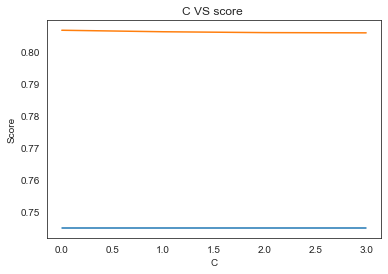

In [100]:
from sklearn.linear_model import LogisticRegression
C = [0.01,0.1,1,10]
train_scores = []
test_scores = []
for i in C:
    clf = LogisticRegression(C = i)
    clf.fit(DF_TrainFinal, y_train)
    test_sc = f1_score(y_test, clf.predict(DF_TestFinal))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('C = ', i,'Train Score', train_sc,'test Score', test_sc)
plt.plot(train_scores, label = 'Train Score')
plt.plot(test_scores, label = 'Test Score')
plt.xlabel('C')
plt.ylabel('Score')
plt.title('C VS score ')

In [97]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [103]:
param_dist = {"C": sp_randint(1,3)}

clf = LogisticRegression(n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions = param_dist,
                                   n_iter = 5, cv = 10, scoring = 'f1', random_state = 25, return_train_score = True)
DF_TrainFinal = DF_TrainFinal.astype(float)
rf_random.fit(DF_TrainFinal, y_train)
print('Testing Scores: Mean', rf_random.cv_results_['mean_test_score'])
print('Training Scores: Mean', rf_random.cv_results_['mean_train_score'])

Testing Scores: Mean [0.81294254 0.81294254 0.81294254 0.8129474  0.8129474 ]
Training Scores: Mean [0.81293099 0.81293099 0.81293099 0.81291506 0.81291506]


In [104]:
clf.fit(DF_TrainFinal, y_train)
y_train_pred = clf.predict(DF_TrainFinal)
y_test_pred = clf.predict(DF_TestFinal)

In [106]:
from sklearn.metrics import f1_score
print('F1 Score: Training = ', f1_score(y_train, y_train_pred))
print('F1 Score: Testing = ', f1_score(y_test, y_test_pred))

F1 Score: Training =  0.812864967633878
F1 Score: Testing =  0.8058755629993436


In [107]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A = (((C.T)/(C.sum(axis = 1))).T)
    
    B = (C/C.sum(axis = 0))
    plt.figure(figsize = (20, 4))
    
    labels = [0,1]
    
    # Representing 'A' in the form of a heatmap
    
    cmap = sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot = True, cmap = cmap, fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot = True, cmap = cmap, fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    
    # Representing B in the form of a heatmap
    
    sns.heatmap(A, annot = True, cmap = cmap, fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Confusion Matrix: Training


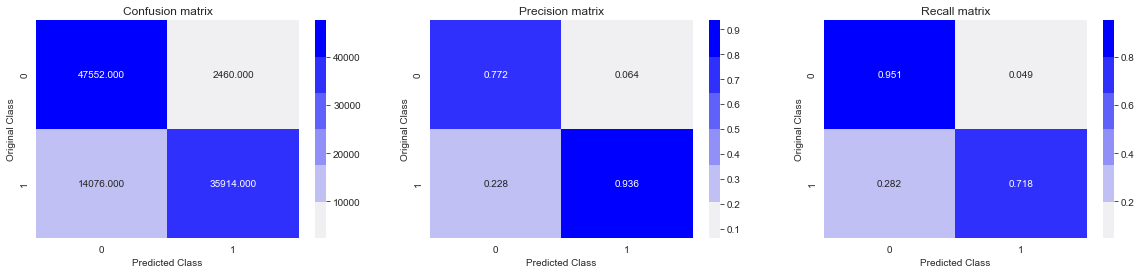

Confusion Matrix: Testing


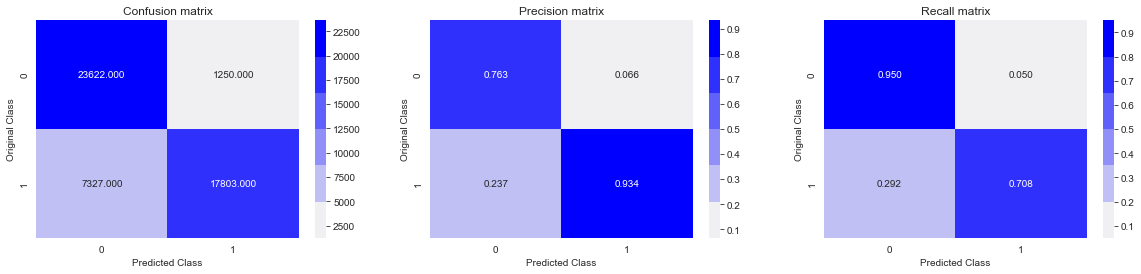

In [108]:
print('Confusion Matrix: Training')
plot_confusion_matrix(y_train, y_train_pred)
print('Confusion Matrix: Testing')
plot_confusion_matrix(y_test, y_test_pred)

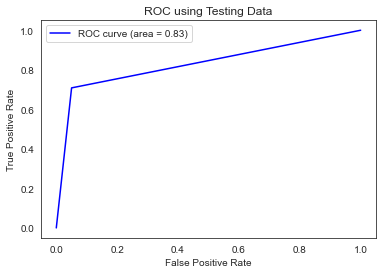

In [109]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color = 'blue', label = 'ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC using Testing Data')
plt.legend()
plt.show()

### Hyperparameter Tuning using Decision Tree

In [110]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

depth =  3 Train Score 0.7450896723101444 test Score 0.7466021596548542
depth =  9 Train Score 0.8324664301725826 test Score 0.8136942325029134
depth =  11 Train Score 0.8370673836043188 test Score 0.8130685624149182
depth =  15 Train Score 0.8427371974277351 test Score 0.8124972841437449
depth =  20 Train Score 0.8421589785569246 test Score 0.8119513987979418
depth =  35 Train Score 0.8421589785569246 test Score 0.8119513987979418
depth =  50 Train Score 0.8421589785569246 test Score 0.8119513987979418
depth =  70 Train Score 0.8421589785569246 test Score 0.8119513987979418
depth =  130 Train Score 0.8421589785569246 test Score 0.8119513987979418


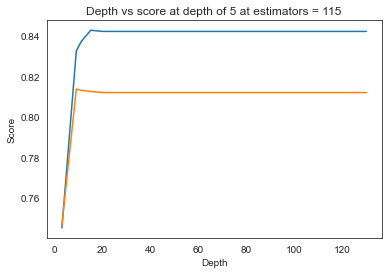

In [112]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = DecisionTreeClassifier(criterion = 'entropy',
            max_depth = i, max_features ='auto', max_leaf_nodes = None,
            min_impurity_decrease = 0.0, 
            min_samples_leaf = 52, min_samples_split = 120,
            min_weight_fraction_leaf = 0.0, random_state = 100)
    clf.fit(DF_TrainFinal, y_train)
    train_sc = f1_score(y_train, clf.predict(DF_TrainFinal))
    test_sc = f1_score(y_test, clf.predict(DF_TestFinal))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ', i, 'Train Score', train_sc, 'test Score', test_sc)
plt.plot(depths, train_scores,label = 'Train Score')
plt.plot(depths, test_scores,label = 'Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [114]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = DecisionTreeClassifier(random_state = 100)

rf_random = RandomizedSearchCV(clf, param_distributions = param_dist,
                                   n_iter = 5, cv = 10, scoring = 'f1', random_state = 100, return_train_score = True)
DF_TrainFinal = DF_TrainFinal.astype(float)
rf_random.fit(DF_TrainFinal, y_train)
print('Testing Scores: Mean', rf_random.cv_results_['mean_test_score'])
print('Training Scores: Mean', rf_random.cv_results_['mean_train_score'])

Testing Scores: Mean [0.83622884 0.83627134 0.83556625 0.83568146 0.83530815]
Training Scores: Mean [0.83983081 0.83979728 0.84349603 0.84327665 0.84559385]


In [118]:
clf.fit(DF_TrainFinal, y_train)
y_train_pred1 = clf.predict(DF_TrainFinal)
y_test_pred1 = clf.predict(DF_TestFinal)

In [119]:
from sklearn.metrics import f1_score
print('F1 score: Training = ', f1_score(y_train, y_train_pred1))
print('F1 score: Testing = ', f1_score(y_test, y_test_pred1))

F1 score: Training =  0.9102885418674893
F1 score: Testing =  0.7929848992558423


In [120]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap = sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot = True, cmap = cmap, fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot = True, cmap = cmap, fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot = True, cmap = cmap, fmt = ".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Confusion Matrix: Training


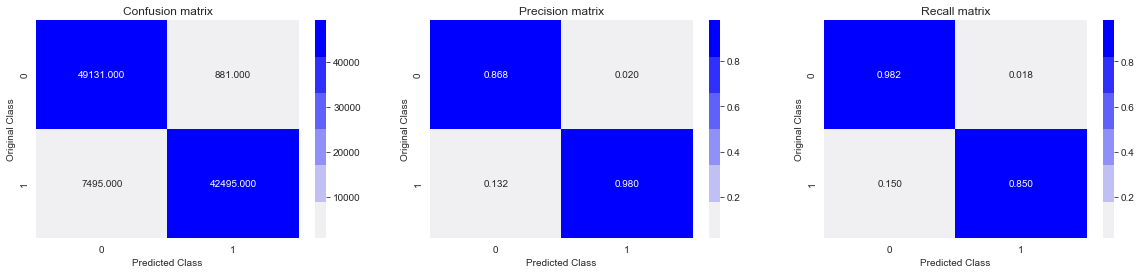

Confusion Matrix: Testing


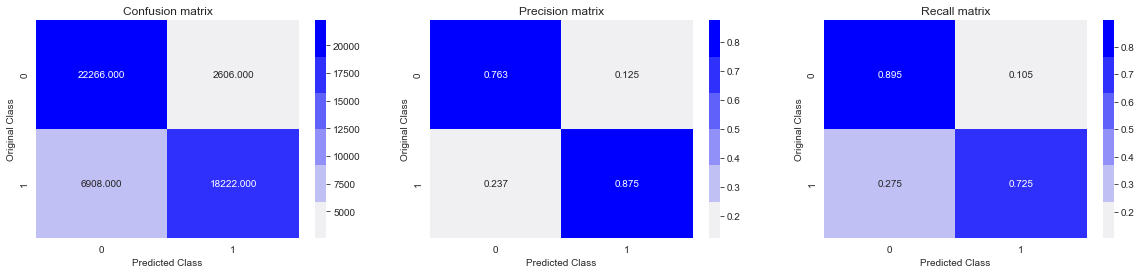

In [121]:
print('Confusion Matrix: Training')
plot_confusion_matrix(y_train, y_train_pred1)
print('Confusion Matrix: Testing')
plot_confusion_matrix(y_test, y_test_pred1)

### Hyperparameter Tuning using SVM

In [122]:
from sklearn.svm import SVC
C = [0.01,0.1]
for i in C:
    model = SVC(C = i)
    model.fit(DF_TrainFinal, y_train)
    train_sc = f1_score(y_train,model.predict(DF_TrainFinal))
    test_sc = f1_score(y_test,model.predict(DF_TestFinal))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('C = ', i ,'Train Score', train_sc,'test Score', test_sc)

C =  0.01 Train Score 0.7769788743580242 test Score 0.7455437201564289
C =  0.1 Train Score 0.8078018317152815 test Score 0.776171015403961


Text(0.5, 1.0, 'C vs score')

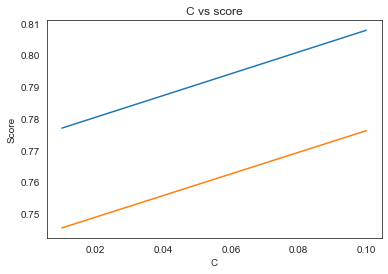

In [123]:
plt.plot(C, train_scores[-2:], label = 'Train Score')
plt.plot(C, test_scores[-2:], label = 'Test Score')
plt.xlabel('C')
plt.ylabel('Score')
plt.title('C vs score')

In [124]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"C": sp_randint(0.1, 0.2)}

model = SVC()

rf_random = RandomizedSearchCV(model, param_distributions = param_dist,
                                   n_iter = 1, cv = 2, scoring = 'f1', random_state = 25, return_train_score = True)
DF_TrainFinal = DF_TrainFinal.astype(float)
rf_random.fit(DF_TrainFinal, y_train)
print('mean test scores', rf_random.cv_results_['mean_test_score'])
print('mean train scores', rf_random.cv_results_['mean_train_score'])

mean test scores [0.8238093]
mean train scores [0.82426851]


In [125]:
model.fit(DF_TrainFinal, y_train)
y_train_pred = model.predict(DF_TrainFinal)
y_test_pred = model.predict(DF_TestFinal)

In [126]:
from sklearn.metrics import f1_score
print('F1 score: Training = ', f1_score(y_train, y_train_pred))
print('F1 score: Testing = ', f1_score(y_test, y_test_pred))

F1 score: Training =  0.8286683818310857
F1 score: Testing =  0.8166336457336213


Confusion Matrix: Training


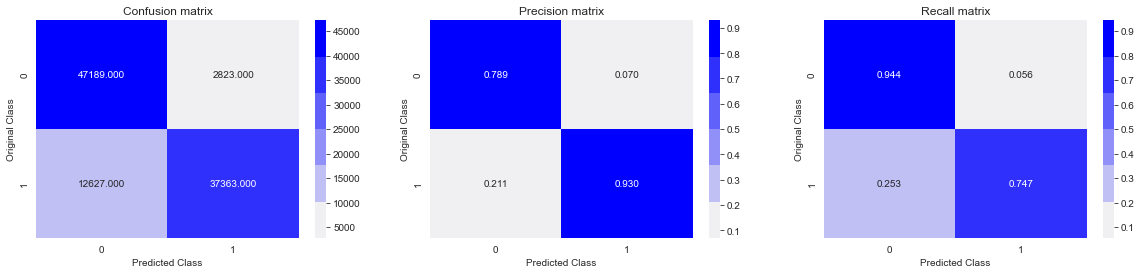

Confusion Matrix: Testing


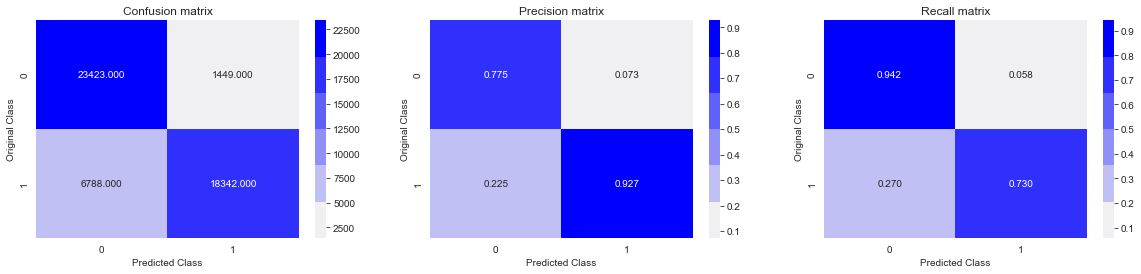

In [127]:
print('Confusion Matrix: Training')
plot_confusion_matrix(y_train, y_train_pred)
print('Confusion Matrix: Testing')
plot_confusion_matrix(y_test, y_test_pred)

## To Conclude:

<img src = "./cartoon-young-standing-woman-thinking-vector-34179787.webp" width = 500>

In [130]:
# Table generated to compare the F1 scores of each model with one another

from prettytable import PrettyTable
k = PrettyTable()

k.field_names = ["Model:", "F1 Score: Training", "F1 Score: Testing"]

k.add_row(["Logistic Regression", 80.20, 78.17])
k.add_row(["Decision Tree", 99.98, 92.04])
k.add_row(["Support Vector Machine", 54.45, 51.66])

print(k)

+------------------------+--------------------+-------------------+
|         Model:         | F1 Score: Training | F1 Score: Testing |
+------------------------+--------------------+-------------------+
|  Logistic Regression   |        80.2        |       78.17       |
|     Decision Tree      |       99.98        |       92.04       |
| Support Vector Machine |       54.45        |       51.66       |
+------------------------+--------------------+-------------------+


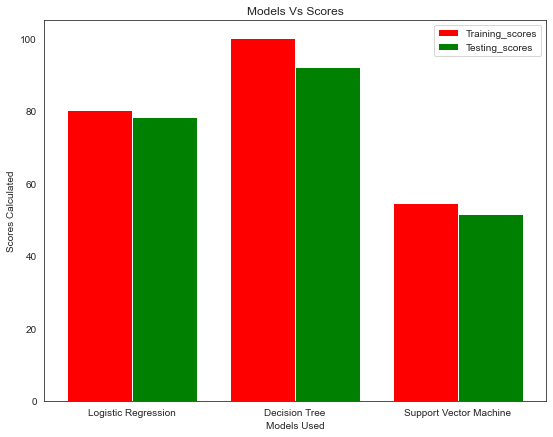

In [131]:
# Graph depicted to compare the F1 scores of each model with one another 

import matplotlib.pyplot as plt
plt.figure(figsize = (9,7))
Models = ['Logistic Regression', 'Decision Tree', 'Support Vector Machine']
Training_Scores = [80.20, 99.98, 54.45]
Testing_Scores = [78.17, 92.04, 51.66]

x_axis = np.arange(len(Models))

plt.bar(x_axis - 0.2, Training_Scores, 0.4, label = 'Training_scores', color = 'r')
plt.bar(x_axis + 0.2, Testing_Scores, 0.4, label = 'Testing_scores', color = 'g')

plt.xticks(x_axis, Models)
plt.xlabel("Models Used")
plt.ylabel("Scores Calculated")
plt.title("Models Vs Scores")
plt.legend()
plt.show()

1.The data obtained from Kaggle consists of two columns called: 'source node' and 'destination node'. The datatype of each column is int64.

2.The aim of our project is to use the given dataset and predict whether two users will become friends in the future.

3.After performing Exploratory Data Analysis, we performed Data Splitting (Train = 80%, Test = 20%) and Data Sampling.

4.Next, we performed Feature Generation using various techniques in order to implement our ML models. Features generated include: Hits Score, Katz Centrality, Cosine Distance, Jaccard Distance etc. 

6.Built 3 Models: a.) Logistic Regression b.) Decision Tree c.) Support Vector Machine

7.Upon Comparing all 3 models we deduced that Decision Tree is the best fit for our Dataset.

References used: 

1.) https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf
2.) https://medium.com/@r.des/7-quick-steps-to-visualize-your-graph-for-machine-learning-with-pythons-dgl-networkx-and-pyvis-df40e71e8f35
3.) https://www.toptal.com/data-science/graph-data-science-python-networkx
4.) https://en.wikipedia.org/wiki/Katz_centrality
5.) https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
6.) https://www.youtube.com/watch?v=2M77Hgy17cg
7.) https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
8.) https://kaggle2.blob.core.windows.net/forum-message-attachments/2594/supervised_link_prediction.pdf
10.) https://www.statisticshowto.com/jaccard-index/
11.)https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html


<img src = "Thanks.jpeg" width = 500>